# Detecção de Fraude em Transações com Cartão de Crédito

## Introdução

A fraude em transações com cartão de crédito é um problema crescente que acarreta grandes prejuízos para instituições financeiras e consumidores. Apesar de representar uma pequena fração das transações totais (aproximadamente 0,17%), a identificação precisa dessas fraudes é essencial para minimizar perdas e garantir a segurança do sistema financeiro.

Este projeto utiliza o dataset [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) do Kaggle, que contém 284.807 transações, das quais apenas 492 são fraudulentas. O objetivo é desenvolver um modelo preditivo capaz de detectar fraudes de forma eficaz, equilibrando alta sensibilidade (recall) e baixa taxa de falsos positivos, em um cenário altamente desbalanceado.


#Importando bibliotecas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix


# Metodologia

1. **Carregamento e inspeção dos dados**  
   Os dados foram importados e inspecionados para verificar valores faltantes, duplicados e entender a estrutura do dataset, que contém 28 variáveis anonimizadas (V1 a V28), além das variáveis `Time`, `Amount` e `Class` (indicador de fraude).

2. **Pré-processamento**  
   - Aplicação do `StandardScaler` para normalização das variáveis `Time` e `Amount`.  
   - Criação de novas features, como `Amount_log` (logaritmo do valor da transação) e extração da variável `Hour` a partir do tempo da transação.  
   - Balanceamento das classes utilizando a técnica SMOTE para gerar amostras sintéticas da classe minoritária.

3. **Divisão dos dados**  
   O dataset foi dividido em conjuntos de treino e teste, mantendo a proporção original das classes (estratificação).

4. **Modelagem**  
   Foram treinados diversos modelos supervisados, incluindo Regressão Logística, Árvore de Decisão, Random Forest, XGBoost e Isolation Forest (modelo para detecção de anomalias). Para garantir a robustez, foi utilizada validação cruzada estratificada.

5. **Avaliação**  
   Os modelos foram avaliados por métricas apropriadas para dados desbalanceados, como AUC-ROC, AUC da curva Precision-Recall e F1-Score. Além disso, foi realizada análise do threshold ideal para equilibrar recall e precisão.

6. **Explicabilidade**  
   A ferramenta SHAP foi utilizada para interpretar o impacto das variáveis nas decisões dos modelos, fornecendo transparência e insights sobre os fatores que influenciam a detecção de fraude.


#Carregando os dados

In [3]:
df0 = pd.read_csv('/content/creditcard.csv', delimiter=',', on_bad_lines='skip')
df = df0.copy()

# Análise Exploratória Inicial dos Dados

In [4]:
df.head(n=5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.tail(n=5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


💬 Observação sobre a Variável `Class`

A variável **`Class`** apresenta uma **média de `0.0018`** e um **desvio padrão de `0.0428`**, o que indica um **forte desbalanceamento entre as classes**.

- A média próxima de zero sugere que **quase todas as amostras pertencem à classe 0**.
- A baixa variação (std) reforça que a **classe 1 ocorre muito raramente** no conjunto de dados.

Esse desbalanceamento pode influenciar negativamente o desempenho de modelos de classificação se não for tratado adequadamente.



In [7]:
df.shape

(284807, 31)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# Tratamento de Dados Duplicados

In [9]:
df.duplicated().sum()

np.int64(1081)

In [10]:
df = df.drop_duplicates()

In [11]:
df.duplicated().sum()

np.int64(0)

# Tratamento de Valores Ausentes

In [12]:
df.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [13]:
df = df.dropna()

In [14]:
df.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


# Distribuição das Classes

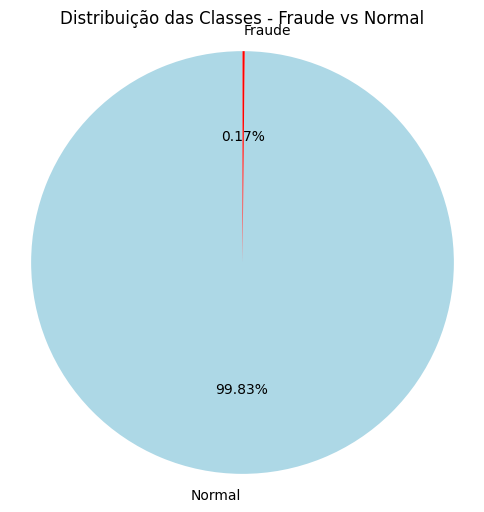

In [15]:
class_counts = df['Class'].value_counts()

labels = ['Normal', 'Fraude']

plt.figure(figsize=(6,6))
plt.pie(class_counts, labels=labels, autopct='%1.2f%%', startangle=90, colors=['lightblue', 'red'])
plt.title('Distribuição das Classes - Fraude vs Normal')
plt.axis('equal')
plt.show()

# Distribuição dos Valores das Transações por Classe

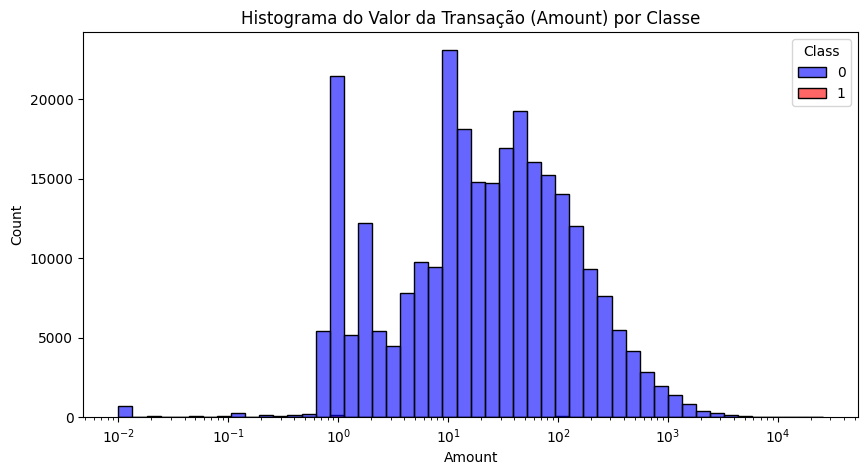

In [16]:
plt.figure(figsize=(10,5))
sns.histplot(df, x='Amount', hue='Class', bins=50, log_scale=True, palette=['blue', 'red'], alpha=0.6)
plt.title('Histograma do Valor da Transação (Amount) por Classe')
plt.show()

# Boxplot do Valor das Transações por Classe

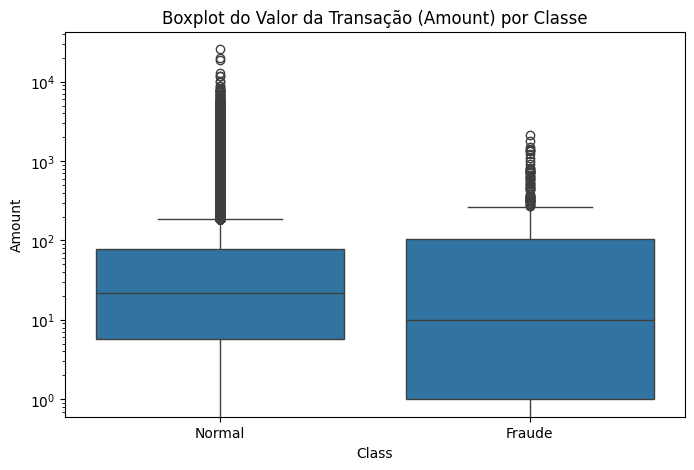

In [17]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Class', y='Amount', data=df)
plt.yscale('log')
plt.xticks([0,1], ['Normal', 'Fraude'])
plt.title('Boxplot do Valor da Transação (Amount) por Classe')
plt.show()

# Mapa de Correlação entre Variáveis

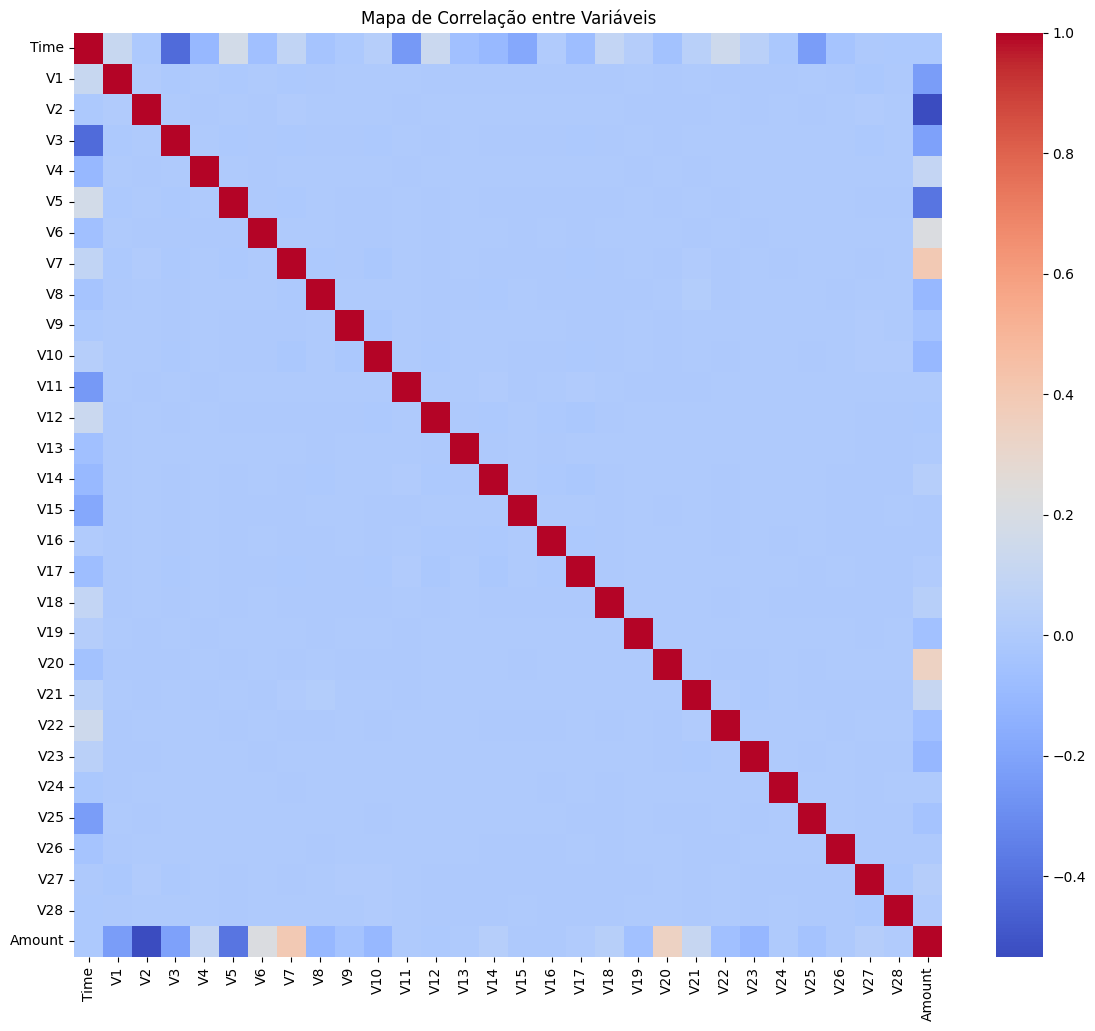

In [18]:
plt.figure(figsize=(14,12))
corr = df.drop('Class', axis=1).corr()
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Mapa de Correlação entre Variáveis')
plt.show()

#  Identificação de Outliers no Valor das Transações

In [19]:
outliers = df[df['Amount'] > df['Amount'].quantile(0.75)]
print(f"\nQuantidade de transações com Amount acima do 75º percentil: {len(outliers)}")


Quantidade de transações com Amount acima do 75º percentil: 70931


In [20]:
outliers = df[df['Amount'] < df['Amount'].quantile(0.25)]
print(f"\nQuantidade de transações com Amount abaixo do 25º percentil: {len(outliers)}")


Quantidade de transações com Amount abaixo do 25º percentil: 70900


# Análise Temporal das Fraudes por Hora do Dia

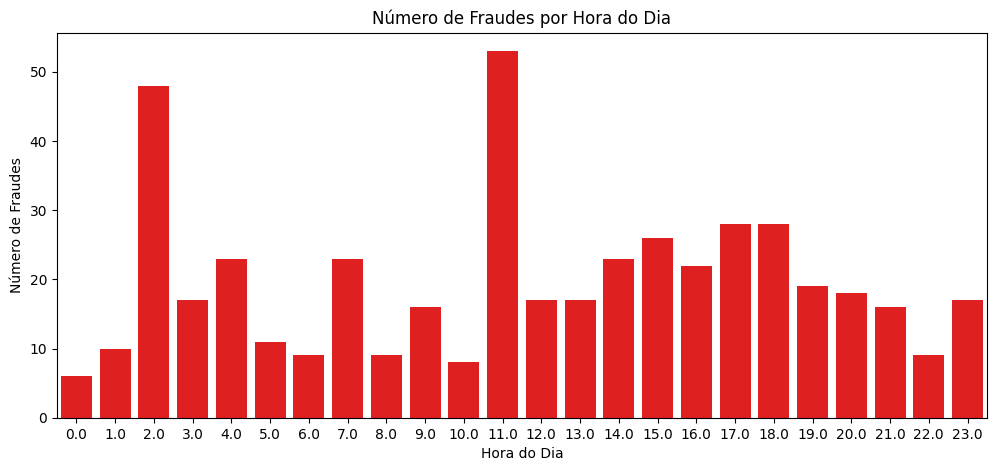

In [21]:
df['Hour'] = (df['Time'] // 3600) % 24

plt.figure(figsize=(12,5))
sns.countplot(x='Hour', data=df[df['Class'] == 1], color='red')
plt.title('Número de Fraudes por Hora do Dia')
plt.xlabel('Hora do Dia')
plt.ylabel('Número de Fraudes')
plt.show()

# Análise Temporal das Transações Normais por Hora do Dia

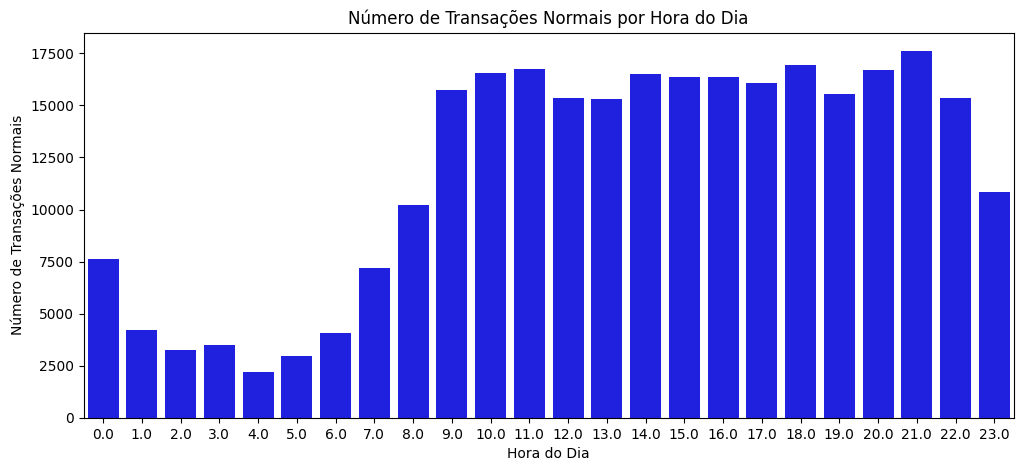

In [22]:
plt.figure(figsize=(12,5))
sns.countplot(x='Hour', data=df[df['Class'] == 0], color='blue')
plt.title('Número de Transações Normais por Hora do Dia')
plt.xlabel('Hora do Dia')
plt.ylabel('Número de Transações Normais')
plt.show()

#Separação dos Dados em Conjunto de Treinamento e Teste

In [23]:
class_counts = df['Class'].value_counts()
print(f"Transações Normais: {class_counts[0]}")
print(f"Transações Fraude: {class_counts[1]}")

Transações Normais: 283253
Transações Fraude: 473


In [24]:
X = df.drop('Class', axis=1)
y = df['Class']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Balanceamento das Classes com SMOTE

In [26]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

 Observação sobre o Balanceamento com SMOTE

Foi aplicado o método **SMOTE (Synthetic Minority Over-sampling Technique)** para balancear as classes no conjunto de treinamento.

- O SMOTE gera **novas amostras sintéticas** da classe minoritária (`Fraude`) com base na similaridade entre os dados existentes.
- Isso resulta em um conjunto de treinamento com **quantidade igual de amostras para cada classe**, o que ajuda o modelo a aprender melhor os padrões da classe minoritária.

>  Importante: O SMOTE foi aplicado **apenas no conjunto de treinamento**, preservando o conjunto de teste com a distribuição original, o que é essencial para uma avaliação realista do modelo.


#Treinamento do Modelo Random Forest

In [27]:

model = RandomForestClassifier(random_state=42)
model.fit(X_train_bal, y_train_bal)

RandomForestClassifier(random_state=42)

# Avaliação do Modelo no Conjunto de Teste

In [28]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print(f"AUC ROC: {auc:.4f}")

[[84961    15]
 [   33   109]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.88      0.77      0.82       142

    accuracy                           1.00     85118
   macro avg       0.94      0.88      0.91     85118
weighted avg       1.00      1.00      1.00     85118

AUC ROC: 0.9585


💬 Observação sobre os Resultados da Avaliação

O modelo **Random Forest** apresentou um desempenho muito consistente na detecção de transações fraudulentas no conjunto de teste, como evidenciado pelas métricas a seguir:

- **🔢 Matriz de Confusão:**  
  O modelo classificou corretamente **84.961 transações legítimas** e **109 transações fraudulentas**, com **15 falsos positivos** e **33 falsos negativos**.

- **🎯 Precisão da Classe Fraudulenta (1):**  
  **88%**, indicando que a maior parte das transações classificadas como fraude realmente são fraudulentas.

- **📈 Recall da Classe Fraudulenta:**  
  **77%**, ou seja, o modelo conseguiu identificar **77% das fraudes reais**, mas ainda deixou de detectar alguns casos.

- **⚖️ F1-Score da Classe 1:**  
  **82%**, representando um bom equilíbrio entre precisão e recall na classe de maior interesse.

- **✅ Acurácia Global:**  
  Praticamente **100%**, o que indica ótimo desempenho geral, embora essa métrica deva ser analisada com cautela devido ao forte desbalanceamento das classes.

- **🚀 AUC ROC:**  
  **0.9585**, indicando uma altíssima capacidade de distinguir entre transações fraudulentas e legítimas — quanto mais próximo de 1, melhor.



# Visualização da Matriz de Confusão

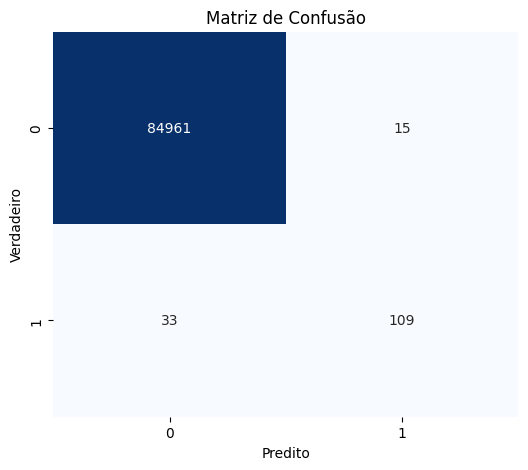

In [29]:
# Calcula a matriz de confusão entre os valores reais e preditos
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()


# Curva ROC (Receiver Operating Characteristic)

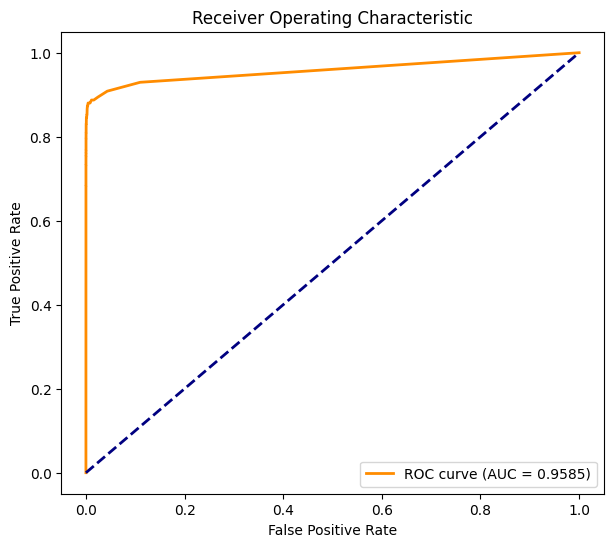

In [30]:
# Calcula as taxas de falso positivo (fpr), verdadeiro positivo (tpr) e os thresholds para a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcula o valor da área sob a curva ROC (AUC)
roc_auc_value = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Curva Precision-Recall

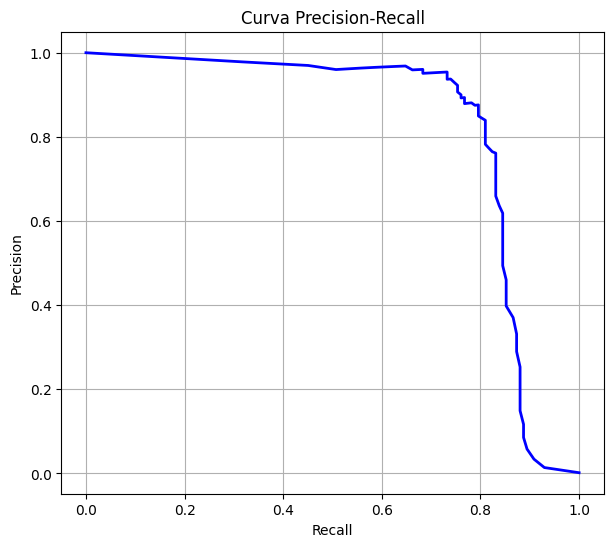

In [31]:
# Calcula as métricas precision, recall e os thresholds correspondentes para diferentes pontos de corte
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(7,6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()

# Conclusão

O projeto conseguiu desenvolver um pipeline eficaz para a detecção de fraudes em transações de cartão de crédito, com modelos supervisionados (notadamente Random Forest) alcançando AUC-ROC próximas de 0,96 e desempenho consistente em métricas de recall e precisão.

A aplicação de técnicas como SMOTE para balanceamento de classes, engenharia de features e explicabilidade via SHAP fortaleceu a qualidade e a confiança do modelo, elementos essenciais para aplicações reais no setor financeiro.
